In [2]:
import os
import numpy as np
from firebase_admin import firestore, initialize_app

initialize_app()

database = firestore.client()
col = database.collection(u'heartfelt_data')

<AxesSubplot: >

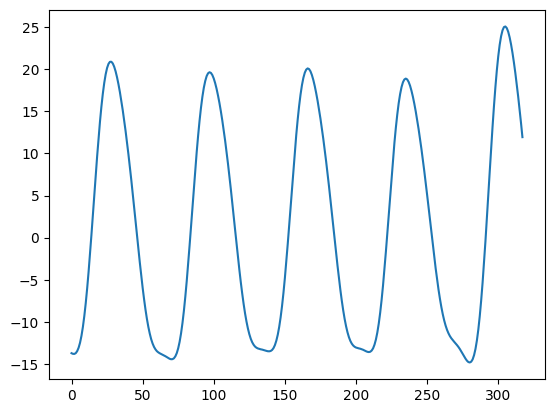

In [3]:
ppg_raw = [-13.715496505544408,-13.790541099816494,-13.800868801654863,-13.706412780556258,-13.465752956754205,-13.062598393979314,-12.467132845565448,-11.651010001698417,-10.5948886582065,-9.298089024857985,-7.774221926602566,-6.01689100036137,-4.0570624223119145,-1.9371208787274687,0.3198913866917259,2.652474285694227,5.015062164322396,7.3606077200283355,9.629592484804773,11.769828059851516,13.755461047941743,15.529421831306642,17.070261341473635,18.35525343392644,19.380454447179314,20.136263080653237,20.624875565598,20.867890873220333,20.874626114039152,20.678057039998464,20.28457525802179,19.733366874935697,19.031642670953048,18.21158219764332,17.283900181508645,16.25141824970097,15.138687040937686,13.943827524020593,12.671181429258432,11.325043698941622,9.90470224083699,8.42147015204161,6.881235057598184,5.284253200240325,3.641493902569374,1.994567127659781,0.32380136854635877,-1.322070406453884,-2.9313259852123466,-4.481688874179999,-5.942314215489489,-7.298934538160335,-8.536223714995524,-9.635917727218592,-10.585841476095785,-11.383406592387944,-12.051676905256635,-12.567726534511326,-12.965685491246303,-13.25638122208043,-13.472679390630244,-13.613502501122252,-13.723225018035118,-13.808224611371763,-13.888298959075923,-13.979108796246958,-14.075392423683157,-14.178213951816506,-14.292115247463142,-14.380977623841149,-14.433173800335851,-14.420741153809903,-14.321065146352984,-14.086072809979331,-13.705135817236373,-13.134869105936994,-12.36458607543474,-11.364837548876817,-10.143026770528305,-8.68943537792492,-7.013005007500467,-5.152093348707039,-3.1113337745763006,-0.9508941601960479,1.2924555558346364,3.5760564184315164,5.847453062429418,8.049992882864654,10.149994767080688,12.093262455020774,13.854698734034045,15.3985675599309,16.71194313143116,17.778826437595363,18.587040104602277,19.17153170817159,19.506441316847443,19.62970548867706,19.5516248949416,19.298594188629785,18.884500512807936,18.328248061711538,17.652358321432864,16.855805862405997,15.973011544176456,14.9809839382761,13.907477444646153,12.74319657638128,11.502936850932969,10.171279326087781,8.769181450332926,7.2998871614675185,5.7600125428534055,4.186755262634048,2.5645374844081474,0.9305383329824912,-0.6780082621121419,-2.2810622384301924,-3.812201954392579,-5.281565304889748,-6.631978630577379,-7.87603011413143,-8.992748167069886,-9.955262730637171,-10.777870402966,-11.456514237092664,-11.996466381555447,-12.408881823317929,-12.70849022984882,-12.92520718659793,-13.061562610121841,-13.151284603835796,-13.204971164155547,-13.25336676904993,-13.287353521222244,-13.339650580780448,-13.384075191941207,-13.439337697892581,-13.482506851773866,-13.491386984354104,-13.453942774766126,-13.335324747302717,-13.11074668072434,-12.751090246723253,-12.224323210666975,-11.519263475225483,-10.601022285085484,-9.468051075139673,-8.118336163694645,-6.55297157340591,-4.784844375580514,-2.8496465413132315,-0.7638950422423947,1.4146646856146807,3.6576968405916563,5.901131109231461,8.105546548994063,10.224250116205015,12.201211366377292,14.007297134445764,15.606824966802424,16.976172039574514,18.098787983277912,18.964341991056372,19.578335134613884,19.946548488819374,20.084651838193327,20.004363588308077,19.737678006631576,19.293600388487032,18.709404612256964,17.992447970070266,17.1578638542262,16.23908129664246,15.222520030834803,14.134685991684032,12.962465177974654,11.728580639905488,10.420803299390293,9.043709280245592,7.608212288311382,6.11377001116888,4.568070122645608,2.992492345136424,1.3921718122415965,-0.20913654906935708,-1.7908560426527815,-3.3300289433112216,-4.809282451741197,-6.1912180490407795,-7.471198437368496,-8.624363870161636,-9.639966389245878,-10.503845416839871,-11.224539912809815,-11.804059843197352,-12.247147146139003,-12.573235575757113,-12.800093631987783,-12.948982767097453,-13.043911367397326,-13.098542827170922,-13.14595238297724,-13.184885056614391,-13.246841401458441,-13.310224858137953,-13.39838464799407,-13.480791587031172,-13.55133244144383,-13.58078726322963,-13.546189325459082,-13.405695567887587,-13.144163045082298,-12.708016528085675,-12.090354571630028,-11.255635184470169,-10.200720446873266,-8.907827533357846,-7.391932362412654,-5.666008353149906,-3.7520696970179035,-1.6894609024569798,0.48237633352842924,2.717100187020886,4.960331024939167,7.156059141333062,9.265975213856263,11.232536773956816,13.022321495630598,14.594578811059073,15.941130811029343,17.024346306103578,17.859757887600335,18.439329810007653,18.772468380607368,18.87625762998304,18.775009454527563,18.482887672238306,18.032909579520556,17.432198069080286,16.71804182075548,15.88926728015249,14.973567465972662,13.970034967110289,12.89204127832112,11.741879215711375,10.522363147103434,9.243099799171274,7.900329165853745,6.507862924181875,5.072186272944146,3.603765904434654,2.1155770212674287,0.6280963595009563,-0.8404291354393485,-2.2758843984728525,-3.649448265098431,-4.949571819585254,-6.158367377785543,-7.251646025134551,-8.235624558115319,-9.092476825719691,-9.82747493676498,-10.441261733805977,-10.945358427616174,-11.35094828187656,-11.679629919756744,-11.940942477760483,-12.16062113874615,-12.359019892799383,-12.550845589535891,-12.75326613986675,-12.973214779480534,-13.222328772374778,-13.496407918471547,-13.790877113233172,-14.082547815304933,-14.366988415781954,-14.604364632282929,-14.766755930691982,-14.817107616850105,-14.723702383978937,-14.448861646894567,-13.949344545092238,-13.207888409835725,-12.195468141262946,-10.900327798423028,-9.318840376764104,-7.45024798754682,-5.329216570562176,-2.970011393275705,-0.4281861998373433,2.259923528819396,5.022122103245664,7.805393149062059,10.54405631440129,13.169548353450782,15.628347439387763,17.865125325246975,19.84326009136505,21.514257708049126,22.87597062455898,23.90115983364494,24.59883171701374,24.988682069952883,25.061387479743075,24.871784951739645,24.436321622948622,23.777605192743017,22.939398516658667,21.939588718872006,20.804531915818284,19.556862678382814,18.20526443231114,16.75839722548031,15.232360812188125,13.61766071410971,11.927272609869034]

import pandas as pd

pd.Series(ppg_raw).plot()